In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [71]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [72]:
def plot_loss(model):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [73]:
class DiabetesPredictor:
    def __init__(self, *args, **kwargs):
        self.df = pd.read_csv('diabetes.csv')
        
    
    def separate_data_and_labels(self):
        df_values = self.df.values
        self.x = df_values[:,:-1]
        self.y = df_values[:, -1].reshape(self.x.shape[0], 1)

    def get_correlation(self):
        correlations = self.df.corr()
        return correlations['Outcome'].sort_values(ascending=False)
        ##aaa
    
    def replace_outliers(self):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        for col in self.df.columns:
            if (col!= "Outcome"):
                #Cálculo de parámetros para obtener los outliers.
                q1 = self.df[col].quantile(0.25)
                q3 = self.df[col].quantile(0.75)
                iqr = q3-q1
                #Límites de los valores tipicos.
                Lower_tail = q1 - 1.5 * iqr
                Upper_tail = q3 + 1.5 * iqr
                #Cálculo de la mediana.
                med = np.median(self.df[col])
                #Reemplazo.
                for i in self.df[col]:
                    if i > Upper_tail or i < Lower_tail:
                            self.df[col] = self.df[col].replace(i, med)

    def replace_nulls(self):
        columns = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
        self.df[columns] = self.df[columns].replace(0,np.NaN)
        median=self.df[columns].median()
        self.df[columns]=self.df[columns].replace(np.NaN,median)

    def remove_cols(self, cols):
        self.df = self.df.drop(['SkinThickness', 'BloodPressure'], axis=1)
    
    def normalize_data(self):
        # Mean, columnar axis.
        x_mean = np.mean(self.x, axis=0, keepdims=True)
        # Std. Deviation, columnar axis.
        x_std = np.std(self.x, axis=0, keepdims=True)
        # Normalizing.
        self.x = (self.x - x_mean)/x_std

    def split_train_test(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.1, random_state=5)
        #nbb

    def model_builder(self,hp):
        model = Sequential()
        model.add(Dense(1,activation='sigmoid', input_shape=(self.x.shape[1],)))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate = hp.Choice('learning_rate', values=[1.0, 0.1, 1e-2, 1e-3, 1e-4, 1e-5])
        

        model.compile(optimizer=optimizers.SGD(momentum=hp_momentum, learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(from_logits=True),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def find_best_hyperparams(self):
        self.tuner = kt.Hyperband(self.model_builder,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='redes_tp2_ej1')
        self.tuner.search(self.x_train, self.y_train, epochs=50, validation_split=0.2)
        self.best_hps=self.tuner.get_best_hyperparameters(num_trials=2)[0]

    def train_model(self, epochs):
        model = self.tuner.hypermodel.build(self.best_hps)
        history = model.fit(self.x_train, self.y_train, epochs=50, validation_split=0.2)

        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
        print('Best epoch: %d' % (best_epoch,))
        #plot_loss(history)
        self.hypermodel = self.tuner.hypermodel.build(self.best_hps)

        # Retrain the model
        self.hypermodel.fit(self.x_train, self.y_train, epochs=25, validation_split=0.2)
        #ifijf

    def make_predictions(self):
        preds = self.hypermodel.predict(self.x_test)
        self.predictions = np.rint(preds)
        #mfigm

    def plot_roc(self):
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(self.y_test, self.predictions)
        auc_keras = auc(fpr_keras, tpr_keras)
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        #igig

    def get_metrics(self):
        print('Specificity: ' + str(specificity(self.y_test.astype(float), self.predictions.astype(float))))
        print('Sensitivity: ' + str(sensitivity(self.y_test.astype(float), self.predictions.astype(float))))
        print('Positive Predictive Value: ' + str(positive_predictive_value(self.y_test.astype(float), self.predictions.astype(float))))
        print('Negative Predictive Value: ' + str(negative_predictive_value(self.y_test.astype(float), self.predictions.astype(float))))
        #figjr
    

In [74]:
predictor = DiabetesPredictor()
predictor.get_correlation()

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

Trial 26 Complete [00h 00m 03s]
val_loss: 0.5294093489646912

Best val_loss So Far: 0.46261128783226013
Total elapsed time: 00h 01m 07s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
18/18 [==============================] - 2s 37ms/step - loss: 0.8337 - auc: 0.4708 - val_loss: 0.5606 - val_auc: 0.7731
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 0.5265 - auc: 0.8009 - val_loss: 0.4856 - val_auc: 0.8439
Epoch 3/50
18/18 [==============================] - 0s 4ms/step - loss: 0.6289 - auc: 0.8050 - val_loss: 0.5888 - val_auc: 0.8370
Epoch 4/50
18/18 [==============================] - 0s 4ms/step - loss: 0.7408 - auc: 0.8081 - val_loss: 0.6568 - val_auc: 0.8383
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 0.7696 - auc: 0.8234 - val_loss: 0.6992 - val_auc: 0.8276
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 0.7880 - auc: 0.8298 - val_loss: 0.7734 - val_auc: 0.8156
Epoch 7/50
18/18 [===========================

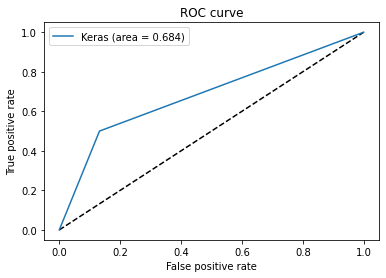

Specificity: tf.Tensor(0.8679245266642933, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.49999999791666666, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6315789440443214, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.7931034469084424, shape=(), dtype=float64)


In [75]:
#predictor.replace_outliers()
#predictor.replace_nulls()
predictor.separate_data_and_labels()
predictor.normalize_data()
predictor.split_train_test()
predictor.find_best_hyperparams()
predictor.train_model(25)
predictor.make_predictions()
predictor.plot_roc()
predictor.get_metrics()